In [1]:
%pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.6 MB/s eta 0:00:00


**Imports**

In [2]:
import torch
import torchvision
from diffusers import DDPMScheduler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from diffusers import DDPMScheduler, UNet2DModel
from torch import nn
from tqdm.auto import tqdm

**Device setting**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


**Download and Prepare MNIST dataset**


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4561667.84it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133697.66it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1275961.53it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8964954.71it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



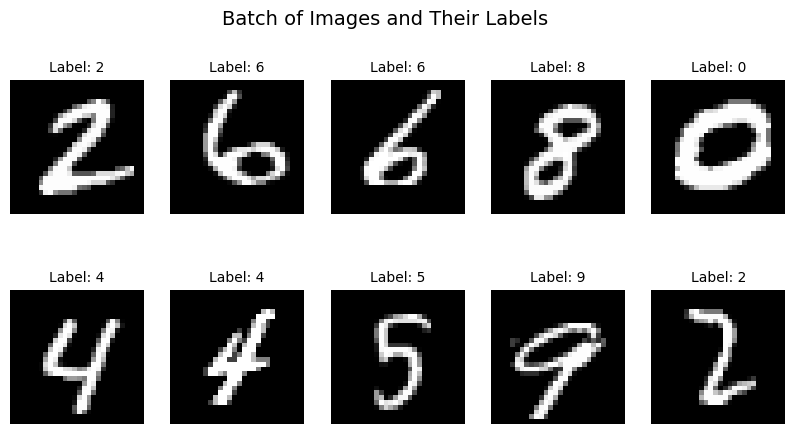

In [4]:
# Load the dataset
dataset = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Get a batch of data
batch = next(iter(train_dataloader))
images, labels = batch

# Plot some images and their labels
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(np.squeeze(images[i].numpy()), cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}', fontsize=10)
    ax.axis('off')


# Add title
plt.suptitle('Batch of Images and Their Labels', fontsize=14)

plt.show()

In [5]:
def plot_noise_image_grid(images, labels=None, ncols=10, figsize=(5, 5), title="", channels_first=True):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    images = np.moveaxis(images, 1, 3) if channels_first and len(images.shape) == 4 else images
    images = images.squeeze()
    N, H, W = images.shape[:3]
    nrows = int(np.ceil(N / ncols))
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    ax = np.ravel(ax)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap="gray")
        ax[i].axis('off')
        if labels is not None and len(labels) > 0:
            ax[i].set_title(f"Label: {str(labels[i])}")
    fig.suptitle(title)
    plt.subplots_adjust(top=1.2)
    plt.show()

**Forward process**

In [47]:
class Noise(torch.nn.Module):
    def __init__(self, beta_range=[1e-4, 2e-2], num_time_steps=200, device="cpu", image_shape=[1,28,28]):
        super(Noise, self).__init__()
        self.beta_range = beta_range
        self.num_time_steps = num_time_steps
        self.device = device
        self.image_shape = image_shape

        self.betas = torch.linspace(start=beta_range[0], end=beta_range[1], steps=num_time_steps).to(device)
        self.alphas = (1 - self.betas).to(device)
        self.alpha_bars = torch.cumprod(self.alphas, dim=0).to(device)

    def forward(self, x0, t, epsilon=None):
        n, c, h, w = x0.shape

        # Following the equation for q(x_t | x_0) we will create a gaussian distribution with some shifted mean and default 1 variance.
        alpha_bar_t = self.alpha_bars[t]
        # For last batch the number of images could be less than actual batch size. So take 'alpha_bar_t' accordingly.
        alpha_bar_t = alpha_bar_t[:n]

        # mean_tensor = alpha_bar_t.sqrt().reshape(n, 1, 1, 1) * x0                   # Make alpha_bar_t of same shape as x0
        # variance_tensor = (1 - alpha_bar_t).sqrt() * torch.Tensor([1.0])           # Variance of gaussian will be 1
        # variance_tensor = variance_tensor.reshape(n, 1, 1, 1)
        # x_t = torch.distributions.Normal(mean_tensor, variance_tensor).sample([1])  # x_t.shape = [1,n,1,1,1], first 1 for 1 sample
        # x_t = x_t[0].to(self.device)                                                # x_t.shape = [n,1,1,1]

        if epsilon is None:
            epsilon = torch.randn_like(x0).to(self.device)
        try:
            x_t = alpha_bar_t.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - alpha_bar_t).sqrt().reshape(n, 1, 1, 1) * epsilon
        except:
            print("x0",x0.shape, alpha_bar_t, n)
        return x_t




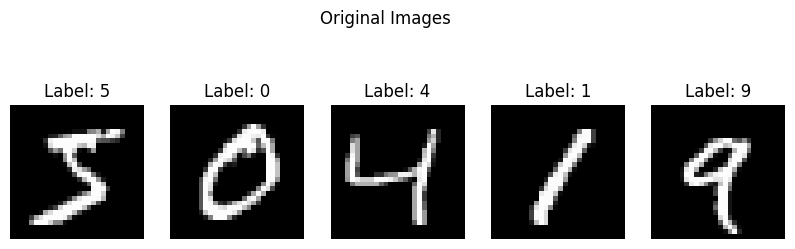

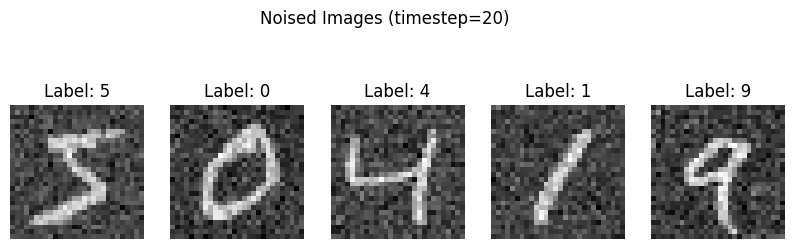

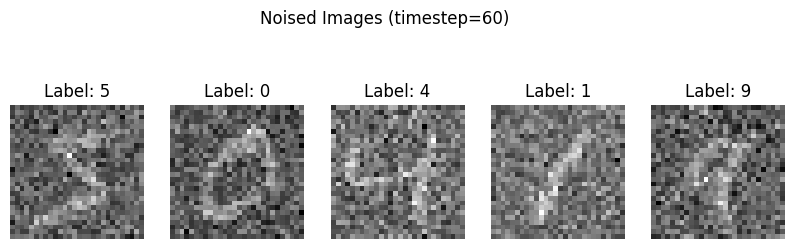

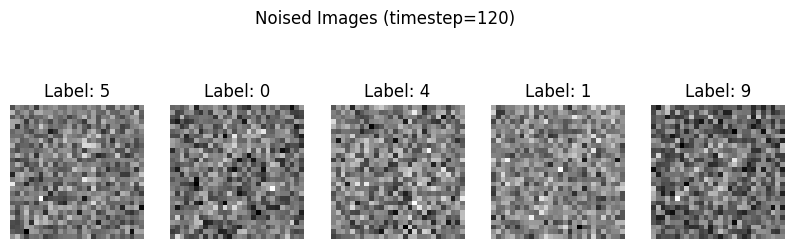

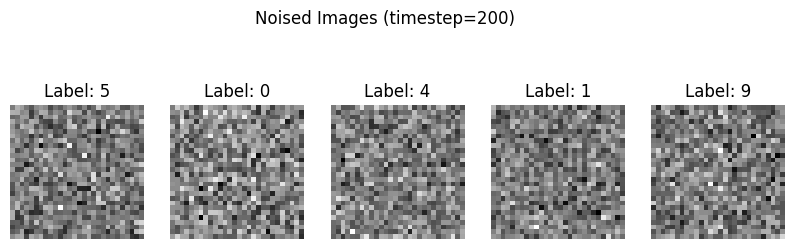

In [48]:
BATCH_SIZE = 5
NUM_STEPS = 201
IMAGE_SHAPE = [1,28,28]
dl_train = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
temp_imgs, temp_targets = next(iter(dl_train))

m = Noise(beta_range=[1e-4, 2e-2], num_time_steps=NUM_STEPS, image_shape=IMAGE_SHAPE)


# Plot initial original images.
plot_noise_image_grid(temp_imgs, temp_targets, ncols=5, title="Original Images", figsize=(10,5))

# Plot images at certain 't' noise level.
x_t = temp_imgs
for t in [20, 60, 120, 200]:
    t_vec = torch.Tensor([t]*BATCH_SIZE).long()
    x_t = m.forward(x_t, t_vec)
    plot_noise_image_grid(x_t, temp_targets, ncols=5, title=f"Noised Images (timestep={t})", figsize=(10,5))


**Network Definition**

In [8]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [9]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='linear')

**Training**

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.033161


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.028276


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.026766


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.025323


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.024749


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.023765


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.024025


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.023151


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.022905


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.022461


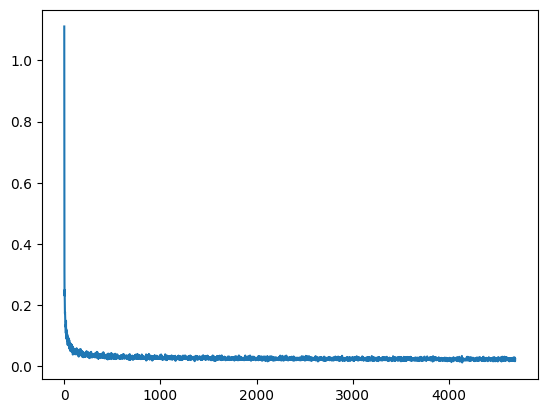

In [59]:


# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())



    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

Please enter the digit you want to plot (0-9): 5


0it [00:00, ?it/s]

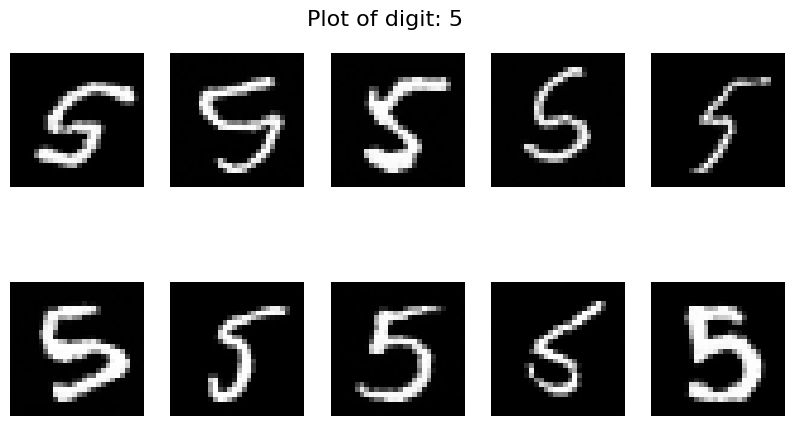

In [66]:
while True:
    try:
        digit = int(input("Please enter the digit you want to plot (0-9): "))
        if 0 <= digit <= 9:
            break
        else:
            print("Please enter a number between 0 and 9.")
    except ValueError:
        print("Please enter a valid integer.")

# Prepare random x to start from, plus some desired labels y
x = torch.randn(10, 1, 28, 28).to(device)
y = torch.tensor([digit]*10).to(device)  # All elements are the user-defined digit

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

def plot_noise_image_grid(images, labels=None, ncols=5, figsize=(10, 5), title="", channels_first=True):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    images = np.moveaxis(images, 1, 3) if channels_first and len(images.shape) == 4 else images
    images = images.squeeze()
    N, H, W = images.shape[:3]
    nrows = int(np.ceil(N / ncols))
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    ax = np.ravel(ax)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap="gray")
        ax[i].axis('off')
    fig.suptitle(title, fontsize=16)  # adjust fontsize of the title
    plt.subplots_adjust(top=0.95, wspace=0.2, hspace=0.2)  # adjust top, wspace, and hspace to prevent overlap
    plt.show()

plot_noise_image_grid(x, y, title=f"Plot of digit: {digit}")
